## 1. Load and Filter Data
This section loads the original dataset and filters sentences where the 'fuel' column has a negative sentiment.

In [1]:
import pandas as pd

# Load the dataset
file_path = "./data/train_preprocess.csv"
df = pd.read_csv(file_path)

# Filter sentences where fuel is negative
negative_fuel_df = df[df['fuel'] == 'negative'][['sentence']]

# Display a sample of the filtered dataset
print(negative_fuel_df.head())


                                              sentence
1    Avanza kenapa jadi boros bensin begini dah ah....
38   dari segi kenyamanan cortez oke lah, tapi baha...
113  kalau sudah di atas 120 km / jam boros banget ...
116          Rush konde konsumsi BBM yang tetap irit .
124  pengalaman saya punya avanza bahan bakar nya l...


## 2. Text Summarization
This section performs text summarization using the TextRank algorithm from the Sumy library.

In [4]:
import spacy
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the SpaCy Indonesian model
nlp = spacy.blank('id')
nlp.add_pipe('sentencizer')

def textrank_summarizer(text, num_sentences=5):
    # Tokenize sentences
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]

    # Convert sentences to TF-IDF vectors
    vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=None)
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Build the graph and rank sentences
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)

    # Rank sentences by their TextRank score
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    # Create a DataFrame with sentence scores
    sentence_scores_df = pd.DataFrame(ranked_sentences, columns=["Score", "Sentence"])

    # Return summary and sentence scores
    summary = " ".join([sent for _, sent in ranked_sentences[:num_sentences]])
    
    return summary, sentence_scores_df

# Combine sentences into one large text for summarization
text = " ".join(negative_fuel_df['sentence'])


# Apply TextRank summarization
summary, sentence_scores = textrank_summarizer(text, 5)

# Display summary
print("Summary:")
print(summary)

# Display sentence scores
sentence_scores.head()        

NameError: name 'custom_tokenizer' is not defined

## 3. Text Similarity
This section computes text similarity between sentences where the fuel column has a negative sentiment.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(negative_fuel_df['sentence'])

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

# Display similarity matrix
import pandas as pd
sim_df = pd.DataFrame(similarity_matrix, index=negative_fuel_df['sentence'], columns=negative_fuel_df['sentence'])
print(sim_df)


sentence                                            Avanza kenapa jadi boros bensin begini dah ah. Baru diisi sudah mau setengah saja .  \
sentence                                                                                                                                  
Avanza kenapa jadi boros bensin begini dah ah. ...                                           1.000000                                     
dari segi kenyamanan cortez oke lah, tapi bahan...                                           0.013448                                     
kalau sudah di atas 120 km / jam boros banget a...                                           0.093155                                     
Rush konde konsumsi BBM yang tetap irit .                                                    0.000000                                     
pengalaman saya punya avanza bahan bakar nya le...                                           0.028798                                     
sudah harga nya mahal, fort

## 4. Text Clustering
This section applies clustering techniques on sentences where the fuel column has a negative sentiment.

                                              sentence  cluster
38   dari segi kenyamanan cortez oke lah, tapi baha...        0
113  kalau sudah di atas 120 km / jam boros banget ...        0
342  walaupun secara keseluruha oke tapi kalo bensi...        0
157  sudah harga nya mahal, fortuner ini juga konsu...        0
499  Grand Livina XV AT 2008 ngelitik nya parah kak...        0
448  xenia 1:8 - 9 boros juga ya juragan , karena b...        0
394  yamaha lexi speed nya gila, tarikan nya juara,...        0
385  ertiga gaya nya oke banget, tarikan juga manta...        0
762                avanza bahan bakar nya boros banget        0
407  secara keseluruhan avanza bagus kecuali pemaka...        1
1    Avanza kenapa jadi boros bensin begini dah ah....        1
276             Asli avanza saya boros akhir-akhir ini        1
419              kalo gak mau boros jangan beli scoopy        1
390            pakai new avanza bu . Boros bensin haha        1
418  Masa konsumsi bensin Toyota Avanza 

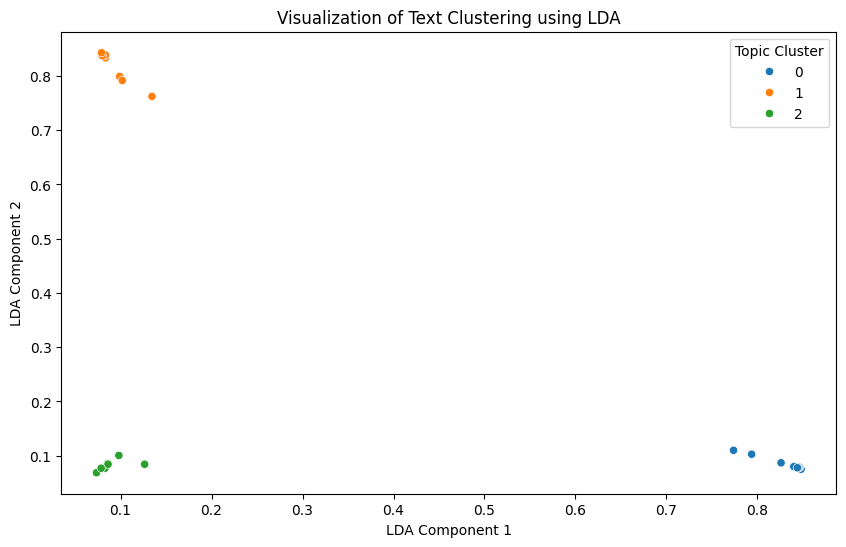

,sentence,LDA_Topic,Topic Words
1,Avanza kenapa jadi boros bensin begini dah ah....,0,"nya, avanza, boros, bakar, bahan, banget, akhi..."
38,"dari segi kenyamanan cortez oke lah, tapi baha...",0,"nya, avanza, boros, bakar, bahan, banget, akhi..."
113,kalau sudah di atas 120 km / jam boros banget ...,2,"punya, memang, xenia, yang, saya, iya, gue, be..."
116,Rush konde konsumsi BBM yang tetap irit .,1,"boros, juga, nya, ya, oke, tapi, dan, jauh, va..."
124,pengalaman saya punya avanza bahan bakar nya l...,2,"punya, memang, xenia, yang, saya, iya, gue, be..."


In [19]:
from sklearn.cluster import KMeans

# Choose number of clusters (can be adjusted)
num_clusters = 3

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
negative_fuel_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Display clustered sentences
print(negative_fuel_df[['sentence', 'cluster']].sort_values(by='cluster'))


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation

# Perform LDA for topic modeling
num_topics = 3  # Adjust the number of topics as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_matrix = lda.fit_transform(tfidf_matrix)

# Assign the most probable topic to each sentence
negative_fuel_df['LDA_Topic'] = np.argmax(lda_matrix, axis=1)

# Visualize the clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=lda_matrix[:, 0], y=lda_matrix[:, 1], hue=negative_fuel_df['LDA_Topic'], palette="tab10")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title("Visualization of Text Clustering using LDA")
plt.legend(title="Topic Cluster")
plt.show()

        



In [20]:
# Function to display the top words for each topic
def display_topics(model, feature_names, num_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[f"Topic {topic_idx}"] = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
    
    # Convert topics to a DataFrame for display
    topics_df = pd.DataFrame(topics)
    
    return topics_df

# Get feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Display the top words in each topic
topics = display_topics(lda, feature_names)
topics.head()

,Topic 0,Topic 1,Topic 2
0,nya,boros,punya
1,avanza,juga,memang
2,boros,nya,xenia
3,bakar,ya,yang
4,bahan,oke,saya


In [21]:
# Function to display the top words for each topic per cluster
def display_cluster_topics(model, feature_names, num_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[f"Topic {topic_idx}"] = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
    
    # Convert topics to a DataFrame for display
    topics_df = pd.DataFrame(topics)

    # Associate topics with clusters
    cluster_topics = negative_fuel_df[['sentence', 'LDA_Topic']].copy()
    cluster_topics['Topic Words'] = cluster_topics['LDA_Topic'].apply(lambda x: ", ".join(topics_df[f"Topic {x}"]))
    
    return cluster_topics

# Get feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Display the top words in each topic per cluster
topic_cluster = display_cluster_topics(lda, feature_names)
topic_cluster.head()        

,sentence,LDA_Topic,Topic Words
1,Avanza kenapa jadi boros bensin begini dah ah....,0,"nya, avanza, boros, bakar, bahan, banget, akhi..."
38,"dari segi kenyamanan cortez oke lah, tapi baha...",0,"nya, avanza, boros, bakar, bahan, banget, akhi..."
113,kalau sudah di atas 120 km / jam boros banget ...,2,"punya, memang, xenia, yang, saya, iya, gue, be..."
116,Rush konde konsumsi BBM yang tetap irit .,1,"boros, juga, nya, ya, oke, tapi, dan, jauh, va..."
124,pengalaman saya punya avanza bahan bakar nya l...,2,"punya, memang, xenia, yang, saya, iya, gue, be..."


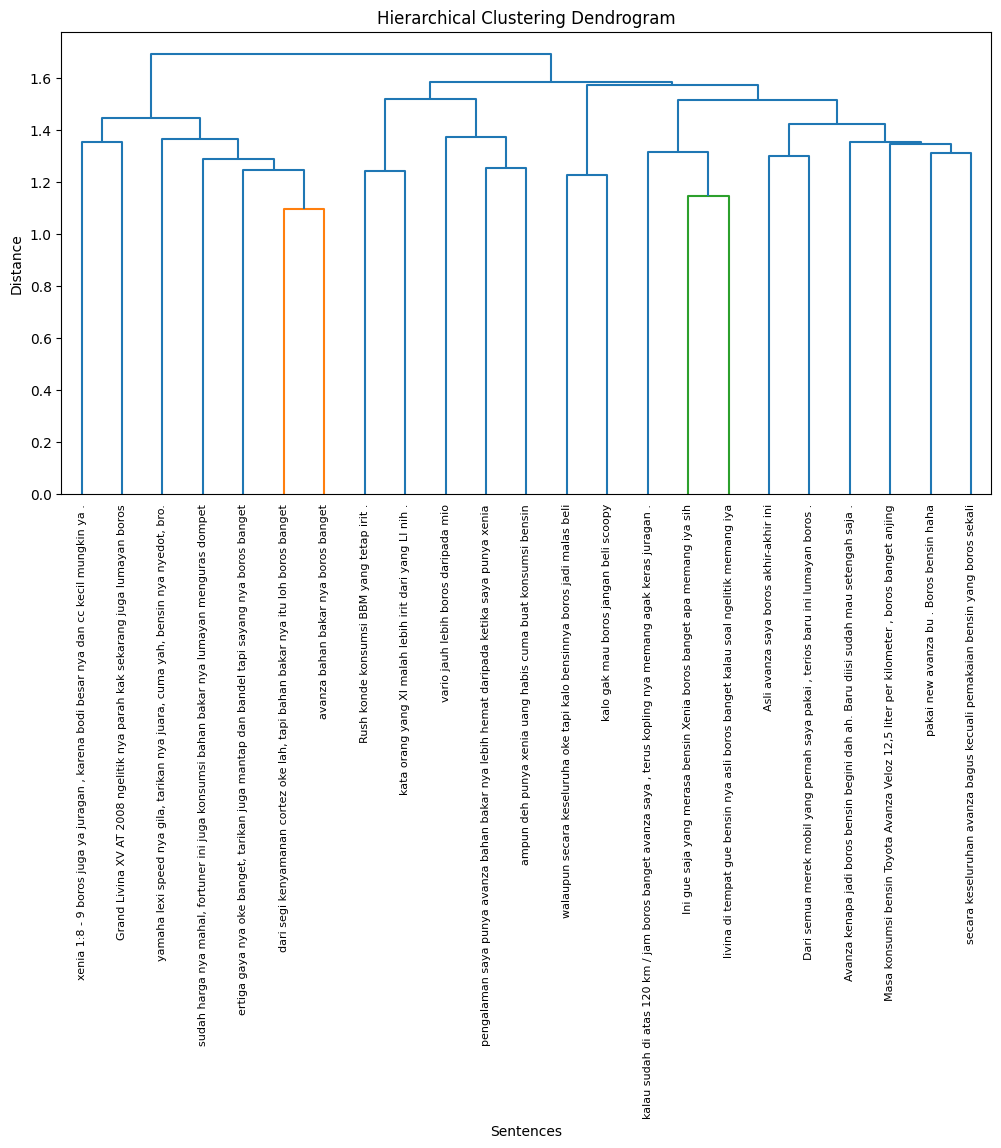

In [22]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linkage_matrix = sch.linkage(tfidf_matrix.toarray(), method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix, labels=negative_fuel_df['sentence'].values, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sentences")
plt.ylabel("Distance")
plt.show()
        

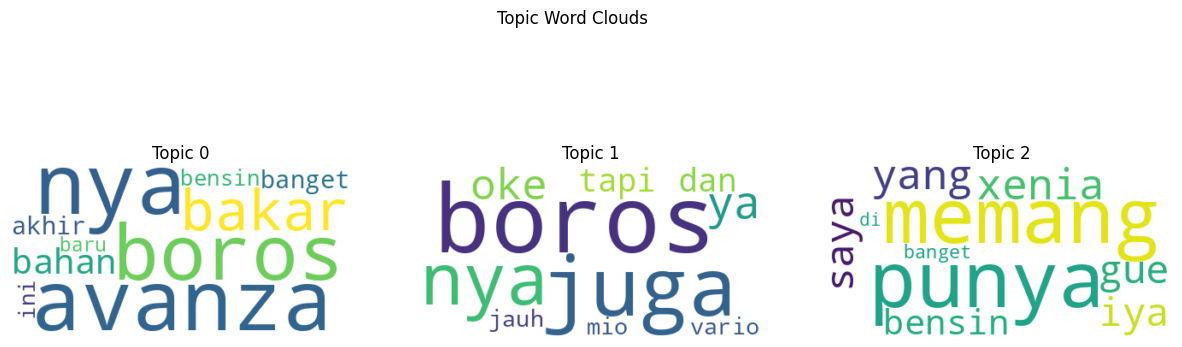

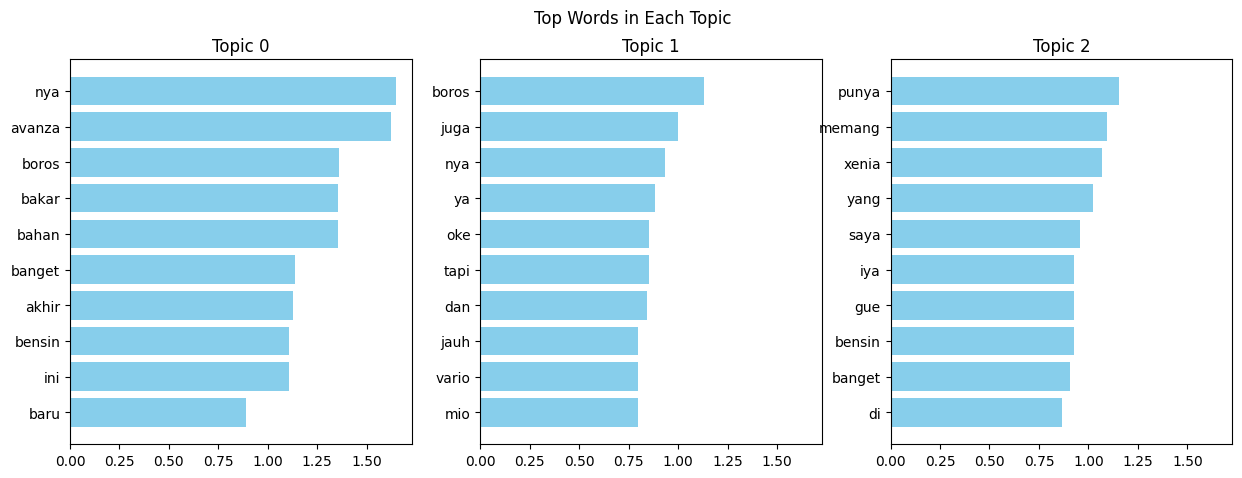

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Function to plot word clouds for topics
def plot_word_clouds(model, feature_names, num_words=10):
    fig, axes = plt.subplots(1, model.n_components, figsize=(15, 5))
    for topic_idx, topic in enumerate(model.components_):
        word_freqs = {feature_names[i]: topic[i] for i in topic.argsort()[:-num_words - 1:-1]}
        wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_freqs)
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].axis("off")
        axes[topic_idx].set_title(f"Topic {topic_idx}")
    plt.suptitle("Topic Word Clouds")
    plt.show()

# Function to plot bar charts of top words per topic
def plot_top_words(model, feature_names, num_words=10):
    fig, axes = plt.subplots(1, model.n_components, figsize=(15, 5), sharex=True)
    for topic_idx, topic in enumerate(model.components_):
        top_features_indices = topic.argsort()[:-num_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_indices]
        top_weights = topic[top_features_indices]

        axes[topic_idx].barh(top_features, top_weights, color='skyblue')
        axes[topic_idx].invert_yaxis()
        axes[topic_idx].set_title(f"Topic {topic_idx}")

    plt.suptitle("Top Words in Each Topic")
    plt.show()

# Get feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Plot word clouds and top words for topics
plot_word_clouds(lda, feature_names)
plot_top_words(lda, feature_names)